In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [7]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [9]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


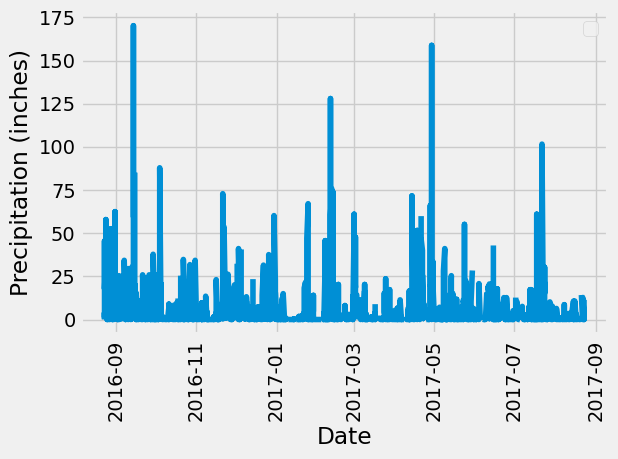

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
last_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = pd.to_datetime(last_date) - pd.DateOffset(years=1)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')
      
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
                            .filter(Measurement.date >= one_year_ago_str)\
                            .order_by(Measurement.date)\
                            .all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure()
plt.plot(df['Date'], df['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=90) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe()
summary_stats

count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

[(9,)]

In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                         .group_by(Measurement.station)\
                         .order_by(func.count(Measurement.station).desc())\
                         .all()
for station, count in active_stations:
    print(f"{station}, {count}")

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Extract the most active station ID from the previous query
most_active_station_id = active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs))\
                           .filter(Measurement.station == most_active_station_id)\
                           .all()
lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"{lowest_temp}, {highest_temp}, {avg_temp}")

12.2, 29.4, 22.03582251082252


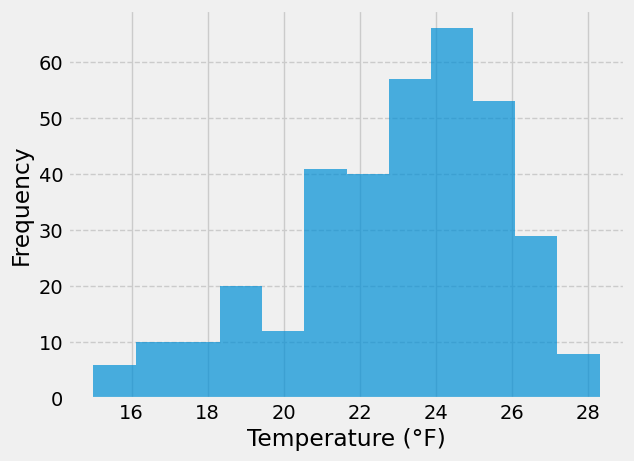

In [38]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs)\
                          .filter(Measurement.station == most_active_station_id)\
                          .filter(Measurement.date >= one_year_ago_str)\
                          .all()

temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure()
plt.hist(temperatures, bins=12, alpha=0.7)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--')
plt.show()

# Close Session

In [39]:
# Close Session
session.close()
